In [1]:
import re

import lxml.html
import matplotlib.pyplot as plt
import pandas as pd
import json
import numpy as np
import torch
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from transformers import BertTokenizer, BertModel

In [2]:
vacancies = pd.read_csv('vacancy.csv', sep='|')
vacancies = vacancies.sample(n=1000, random_state=42)

/tmp/ipykernel_13176/4033342629.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  vacancies = pd.read_csv('vacancy.csv', sep='|')


In [3]:
columns = ['additional_requirements', 'busy_type', 'languageKnowledge', 'education', 'education_speciality',
           'hardSkills', 'softSkills', 'position_requirements', 'position_responsibilities',
           'regionName', 'required_drive_license', 'salary', 'salary_min', 'salary_max', 'schedule_type',
           'vacancy_name', 'professionalSphereName']

In [4]:
vacancies = vacancies[columns]
vacancies = vacancies.fillna('')
vacancies.head()

,additional_requirements,busy_type,languageKnowledge,education,education_speciality,hardSkills,softSkills,position_requirements,position_responsibilities,regionName,required_drive_license,salary,salary_min,salary_max,schedule_type,vacancy_name,professionalSphereName
523915,,Полная занятость,[],Высшее,,"[{""hard_skill_name"":""ответственность"",""owner_i...",[],,,Омская область,[],от 23000,23000.0,30000.0,Полный рабочий день,Инженер по патентной и изобретательской работе,"Образование, наука"
422702,,Полная занятость,[],Не указано,,[],[],"<ul> <li>&nbsp;&nbsp;ответственность, исполнит...","<ul> <li>&nbsp;&nbsp;Укладка вручную изделий, ...",Нижегородская область,[],от 50000,50000.0,50000.0,Полный рабочий день,Упаковщик,Производство
638441,<p>прохождение медицинского осмотра</p>,Полная занятость,[],Не указано,,[],[],<p>опыт работы</p>,<p>согласно должностной инструкции</p>,Астраханская область,[],от 16242,16242.0,16242.0,Полный рабочий день,Слесарь по обслуживанию тепловых сетей,"ЖКХ, эксплуатация"
43233,<p>Вакансия учитель физики для работы в Обласн...,Частичная занятость,[],Высшее,Педагогическое образование,[],[],"<p>Ответственность, дисциплинированность&nbsp;...",,Архангельская область,[],от 4000,4000.0,0.0,Неполный рабочий день,Учитель физики,"Образование, наука"
536417,,Временная,[],Не указано,,[],[],<p>Квалификационное удостоверение по профессии...,<p>Должностные обязанности согласно производст...,Республика Саха (Якутия),[],от 110714,110714.0,0.0,Полный рабочий день,Крепильщик 5 разряд (30766),Добывающая промышленность


In [5]:
# ФУНКЦИИ ОБРАБОТКИ ДАТАСЕТА

# функция предобработки поля "languageKnowledge"
def lang_preprocessing(text):
    obj = json.loads(text)
    lang_str = ''
    for i in range(len(obj)):
        try:
            lang_str += obj[i]['level'] + ' ' + obj[i]['code_language'] + ' язык' + ' '
        except:
            try:
                lang_str += obj[i]['code_language'] + ' язык' + ' '
            except:
                pass
    return lang_str.strip().lower()


# функция предобработки полей навыков
def skills_preprocessing(text, skill_name):
    skills_str = ''
    try:
        obj = json.loads(text)
        for i in range(len(obj)):
            skills_str += obj[i][skill_name] + ' '
        return skills_str.strip().lower()
    except:
        return skills_str.strip().lower()


# функция предобработки поля 'required_drive_license'
def drive_license_preprocessing(text):
    drive_license_str = ''
    try:
        obj = json.loads(text)
        if len(obj) > 0:
            drive_license_str = 'права категории '
        for i in range(len(obj)):
            drive_license_str += obj[i] + ' '
        return drive_license_str.strip().lower()
    except:
        return drive_license_str.strip().lower()



In [6]:
vacancies['languageKnowledge'] = vacancies['languageKnowledge'].apply(lambda text: lang_preprocessing(text))
vacancies['hardSkills'] = vacancies['hardSkills'].apply(
    lambda text: skills_preprocessing(text, skill_name='hard_skill_name'))
vacancies['softSkills'] = vacancies['softSkills'].apply(
    lambda text: skills_preprocessing(text, skill_name='soft_skill_name'))
vacancies['required_drive_license'] = vacancies['required_drive_license'].apply(
    lambda text: drive_license_preprocessing(text))

In [7]:
def clean_text(text):
    try:
        doc = lxml.html.fromstring(text)
        return doc.text_content().replace('\xa0', '')
    except:
        return text


texts = []

for _, row in vacancies.iterrows():
    text = ''
    for col in columns:
        cleaned = str(clean_text(row[col]))
        cleaned = cleaned.lower()
        if cleaned == '':
            continue
        text += cleaned + ' '
    text = re.sub(r'\s+', ' ', text)
    texts.append(text)

In [8]:
example_text = texts[228]
example_text

'полная занятость не указано - уборку снега и льда, подметание проезжей части дорог и тротуаров улиц, посыпку их песком - сгребание и откидывание снега - наблюдение за санитарным состоянием обслуживаемой территории - рытье и прочистку канавок и лотков для стока воды - очищать от снега и льда пожарные колодцы для свободного доступа к ним - поливать мостовые, тротуары, зеленые насаждения, клумбы и газоны краснодарский край от 24500 24500.0 24500.0 полный рабочий день уборщик территории рабочие специальности '

In [9]:
model_name = 'DeepPavlov/rubert-base-cased'

tokenizer = BertTokenizer.from_pretrained(model_name)
example_inputs = tokenizer(example_text, return_tensors='pt')
example_inputs

{'input_ids': tensor([[   101,  35040,  89275,   1699,  27031,    130, 112664,  39740,    851,
          32990,    128,  30570,  72996,   1662,  61889,   5931,   7506,    851,
          50269,   4699,  14653,    128,  89536,   3247,   3806,  71947,    130,
          24359,   4332,   3293,    851,   4603,  15252,  63536,    842,  39740,
            130,  39903,   1758,  27364,   2010,  40276,  25690,  18215,   5735,
            130,   8678,  68308,    851,  11560,   1786,   3247,  98105,   1770,
            851,  31075,   2570,   2748,  59424,  12240,    130,  32643,   2110,
           1641,  39740,    851,  32990,  44255, 114851,   2748,  26053,  23351,
            861,   9680,    130,  80622,   2110,  36713,   2604,    128,  50269,
          10061,    128,  77910,  86915,    128,   4334, 102418,    851, 108903,
            880,  61316,  17977,  11172,   1641,  26365,   3385,  26365,   3385,
            132,    136,  26365,   3385,    132,    136,  21228,  25266,   6622,
          2860

In [10]:
model = BertModel.from_pretrained(model_name, output_hidden_states=True)
model.eval()
with torch.no_grad():
    example_outputs = model(**example_inputs)
    example_hidden_states = example_outputs['hidden_states']
    example_embedding = example_hidden_states[-2][0].mean(dim=0)
    print(example_embedding.shape)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([768])


In [11]:
def vectorize_text(text):
    inputs = tokenizer(text, return_tensors='pt')
    if inputs['input_ids'].shape[-1] > 512:
        inputs['input_ids'] = inputs['input_ids'][..., :512]
        inputs['token_type_ids'] = inputs['token_type_ids'][..., :512]
        inputs['attention_mask'] = inputs['attention_mask'][..., :512]
    with torch.no_grad():
        outputs = model(**inputs)
        hidden_states = outputs['hidden_states']
        embedding = hidden_states[-2][0].mean(dim=0)
        return embedding.numpy()

In [12]:
vectorized_texts = np.stack(list(map(vectorize_text, texts)))
vectorized_texts.shape

(1000, 768)

In [13]:
ks = range(2, 50)
ssr = []
dbs = []

for k in ks:
    model = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    model.fit(vectorized_texts)
    ssr.append(model.inertia_)
    dbs.append(davies_bouldin_score(vectorized_texts, model.predict(vectorized_texts)))

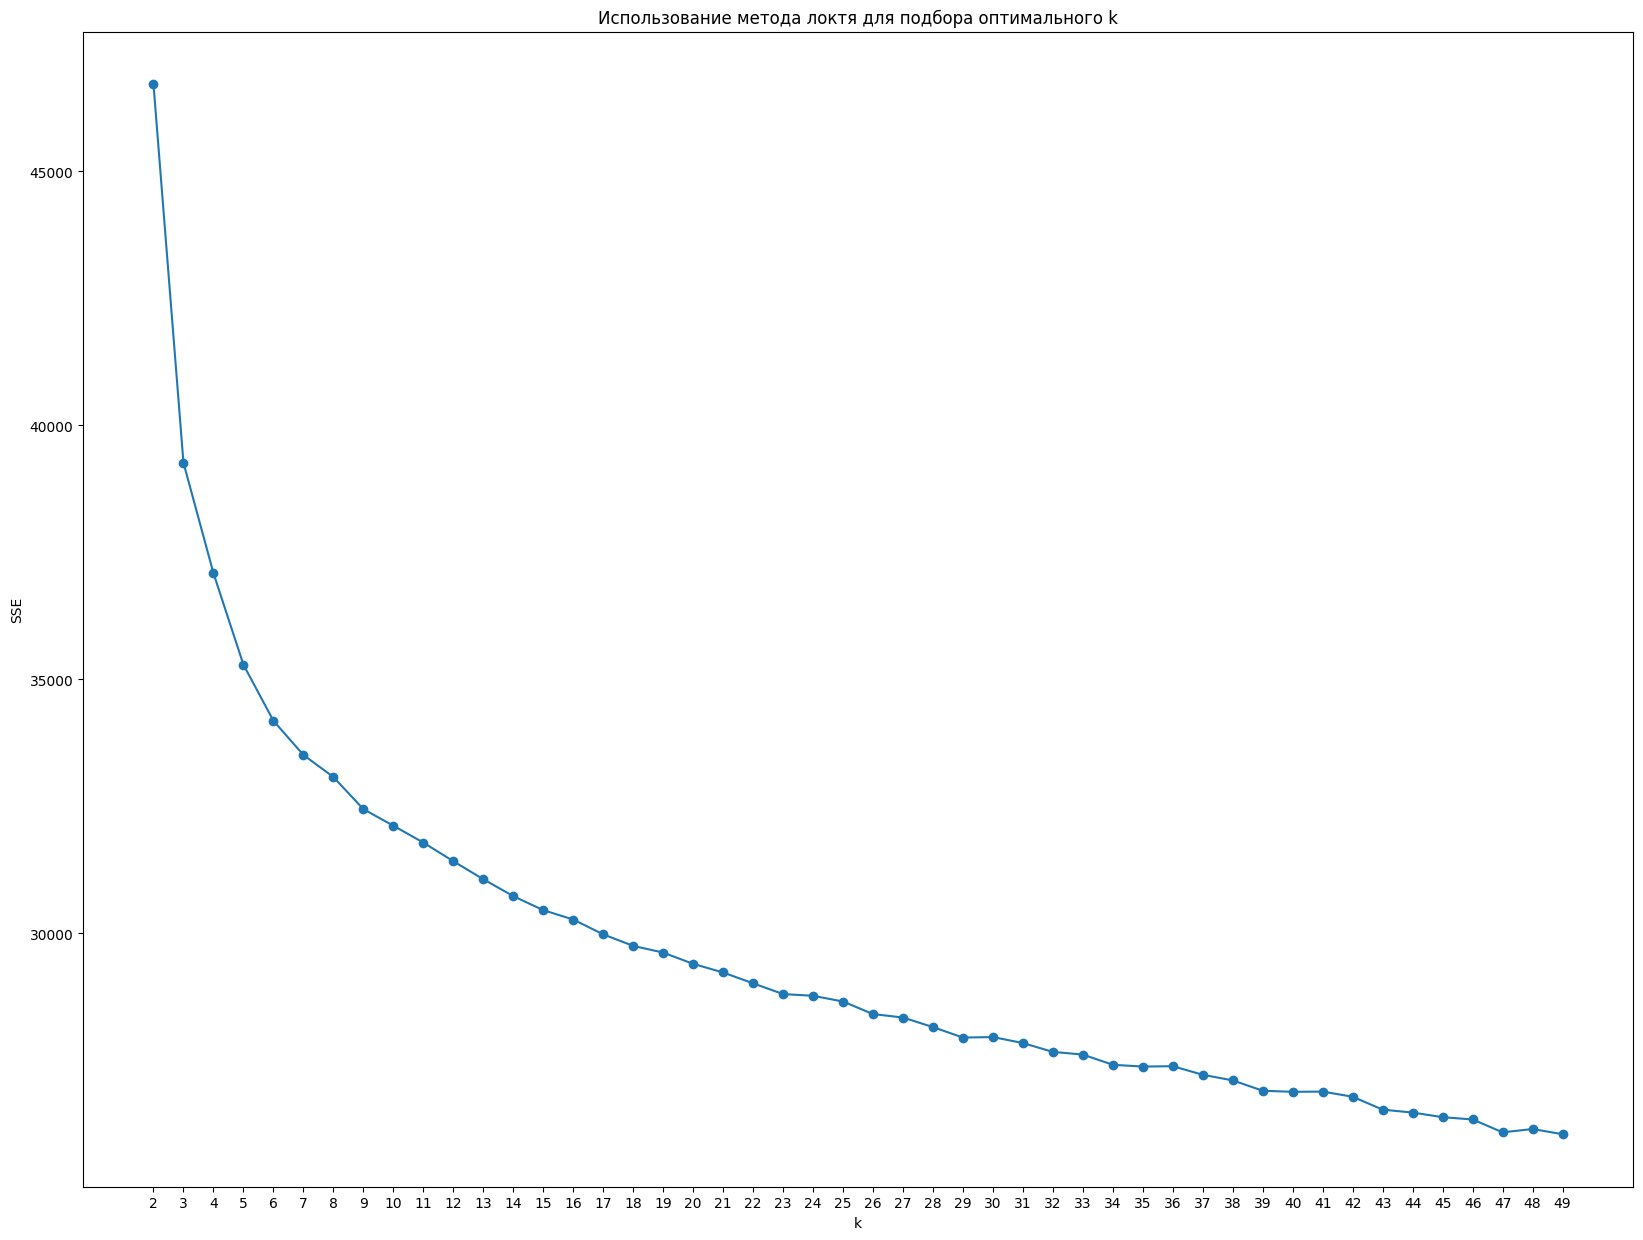

In [14]:
plt.figure(figsize=(20, 15))
plt.plot(ks, ssr, '-o')
plt.xlabel('k')
plt.ylabel('SSE')
plt.xticks(ks)
plt.title('Использование метода локтя для подбора оптимального k')
plt.show()

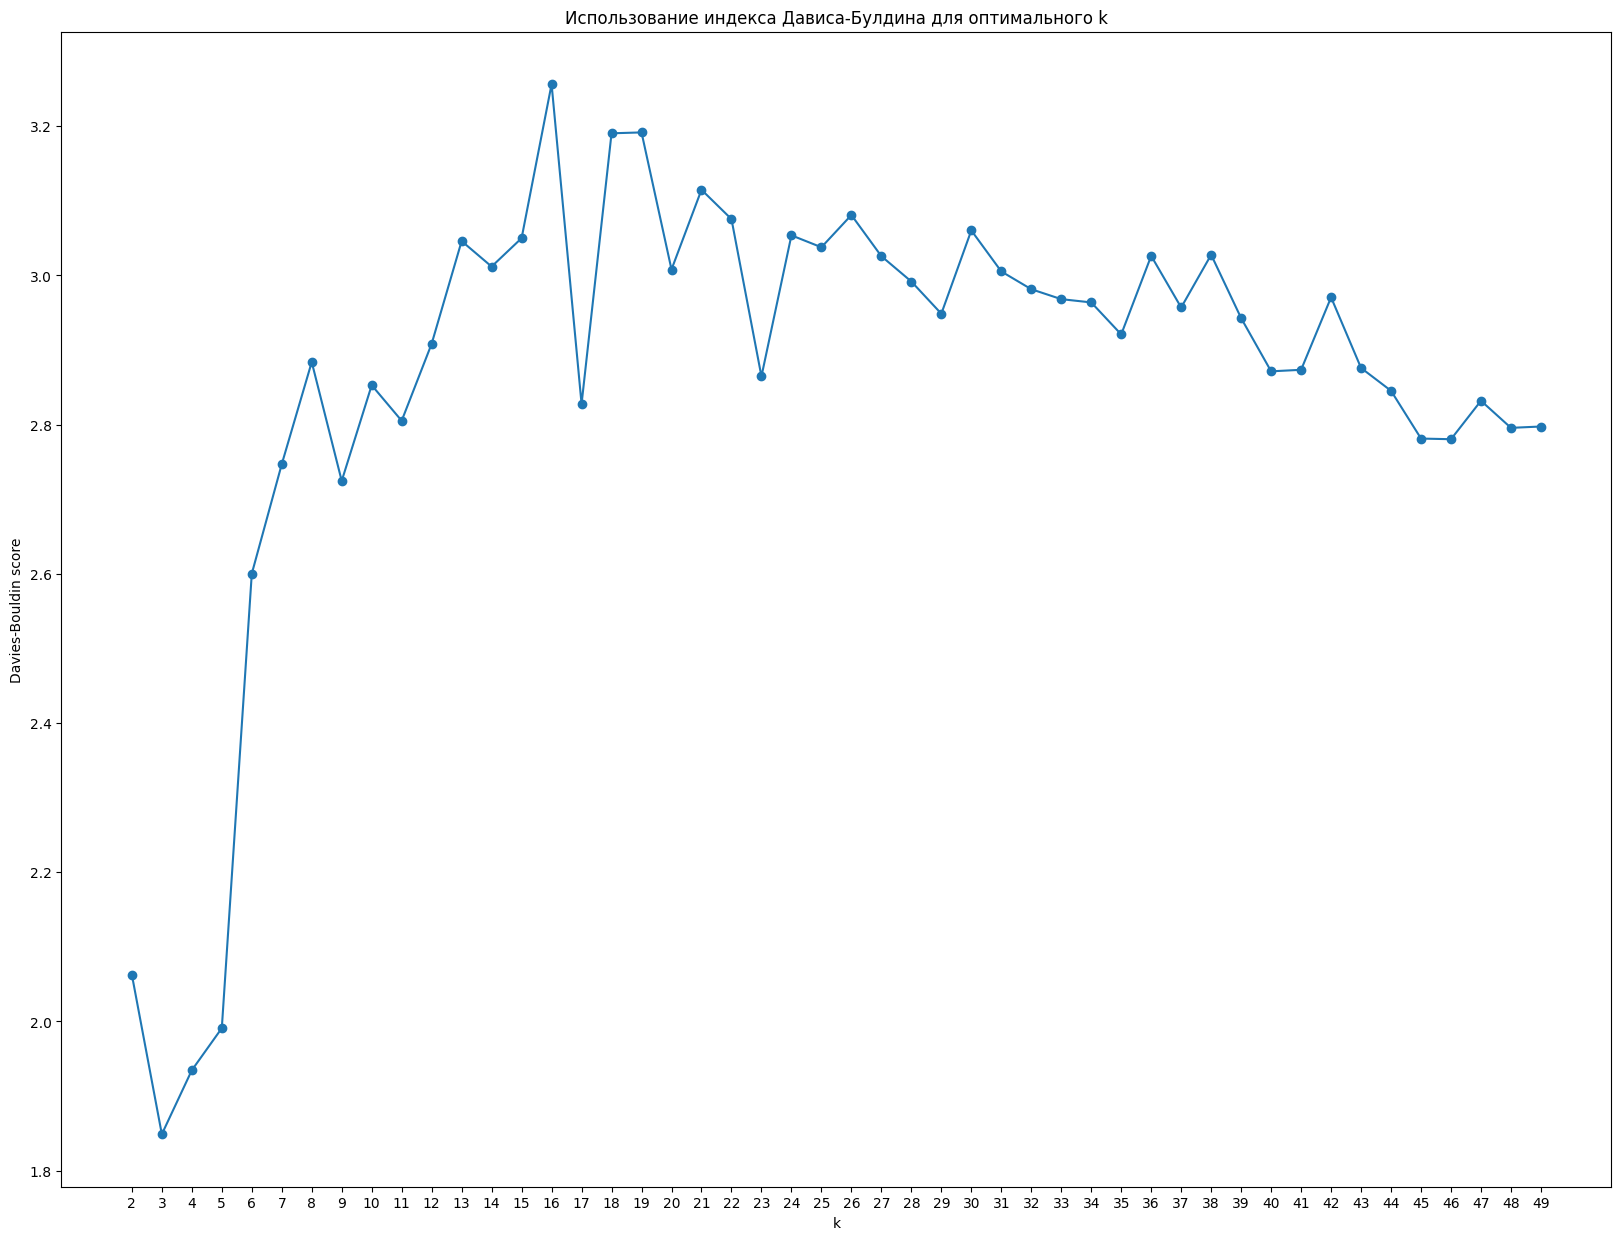

In [15]:
plt.figure(figsize=(20, 15))
plt.plot(ks, dbs, '-o')
plt.xlabel('k')
plt.ylabel('Davies-Bouldin score')
plt.xticks(ks)
plt.title('Использование индекса Дависа-Булдина для оптимального k')
plt.show()